In [17]:
# Leer imagenes satelitales (.nc) 
from netCDF4 import Dataset, num2date

# Graficos y visualizaciones
#import cartopy.crs as ccrs
#import cartopy.feature as cfw
import matplotlib.pyplot as plt
import plotly.express as px

# Liberias para manejo de datos
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Liberias estandar
import re
import time
import os
import datetime

In [18]:
"""
DEFINIMOS EL PATH DEL PROYECTO 
"""
with open('../../path_base.txt') as f:
    path_base = f.read()
path_base

'C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/FinalTesis/Tesis2-DiegoParedes'

In [19]:
"""
Variables generales
"""
path_imagenes = 'F:/GOES/' 

dsName = 'dsCompletoPP_V2'
dsName = 'GTMTime_Base'


#listDataset = [f'{path_base}/Archivos/Dataset/Clasificacion/ClaseV2_CompletoDS.csv']           
listDataset = [f'{path_base}/Archivos/Inicial/GTMTime_Base.csv']

#Variables generales
products = ['C07','C08','C13']
times   = ['10','20','30','40','50','00']


In [20]:
# Filtra por flags (V1, V2)
def limpiarDatos(listNames, path_imagenes, p, read=True):    
    df = []
    start_time = time.time()
    print(f'Se leera los archivos de datasets...')
    if read:
        for name in listNames:
            try:
                df.append(pd.read_csv(name))   
            except:
                print(f'No se pudo leer el archivo {name} de dataset')
                return -1

        if len(df)>1:
            dsCompleto =  pd.concat(df, ignore_index=True) 
        else:
            dsCompleto =  df[0]
    else:
        dsCompleto = listNames
        
        
    print("Tiempo tomado: %.2fs" % (time.time() - start_time))
    print(f'+Cantidad de datos leidos {len(dsCompleto)}')
    
    # Quitamos los NA valores, negativos y mayores a 400
    print(f'\nSe elimnara los valores nulos y dudosos')
    dsCompleto.dropna(subset=['dato'], axis='index', inplace=True)    
    dsCompleto = dsCompleto[dsCompleto['flag']!='ND']
    dsCompleto = dsCompleto[dsCompleto['dato']>=0]
    dsCompleto = dsCompleto[dsCompleto['dato']<400]
    print("Tiempo tomado: %.2fs" % (time.time() - start_time))
    print(f'+Cantidad de datos luego de elimnar nulos {len(dsCompleto)}')
    
    if p['menor']:
        dsCompleto = dsCompleto[(dsCompleto['dato']>p['menor'])]   
    
    if p['mayor']:
        dsCompleto = dsCompleto[(dsCompleto['dato']<p['mayor'])]   
    
    
    # Seleccionamos FLAGS
    if not p['ceros']:
        dsCompleto = dsCompleto[~(dsCompleto['dato']==0)]    
        
    if p['flags']:
        dsCompleto = dsCompleto[dsCompleto['flag'].isin(p['flags'])]    
    if p['flagV2']:
        dsCompleto = dsCompleto[dsCompleto['flagV2'].isin(p['flagV2'])]                   
                             
    print(f'-------> CANTIDAD FINAL DE DATOS :  {len(dsCompleto)} <--------------')  
    print("Tiempo total: %.2fs" % (time.time() - start_time))
    return shuffle(dsCompleto)

In [21]:
# Separa el df en tres grupos (0, entre 0 y 1, mayor a 1) y luego escoje un porcentaje (porc) de cada uno
# V3 : Se va dividr ademas por fecha para evitar que grupos de precipitaciones extremas aparezcan en diferentes datasets 
def getBalancedDataset(df_completo, porc, p):
    niv_sep = p['niv_prec']
    stratify = p['stratify']
    col_prec = p['col_prec']
    random_state = p['random_state']
    
    if p['redTipo'] == 'Regresion':  
        
        return train_test_split(df_completo, test_size=porc, shuffle=True, random_state=random_state)
    
    # Separamos por index
    df = df_completo.groupby(p['index']).max()
    listP = []
    listT = []        
    
    # Separamos por nivel de preciptiacion
    df[col_prec] = (df[col_prec]<=niv_sep).astype(int)
    df['stratify'] =  df[stratify].astype(str) + df[col_prec].astype(str)
    dfTrain, dfPrueba =  train_test_split(df, test_size=porc, shuffle=True, stratify=df['stratify'],random_state=random_state)
    
          
    dfTrain = df_completo[df_completo[p['index']].isin(dfTrain.index)]
    dfPrueba = df_completo[df_completo[p['index']].isin(dfPrueba.index)]
    
    return dfTrain, dfPrueba    

In [22]:
# Se para un dataset (listNames) en pruebas, validacion y entrenamiento
def getModelo_DS(listNames, path_imagenes, p,comentario='', read=True):
    print(f'Tipo de dataset: {p["redTipo"]}')
    # Limpiamos en dataset    
    #dfLimpio = pd.read_csv(listNames[0])
    dfLimpio = limpiarDatos(listNames, path_imagenes, p, read)    
    dfLimpio.to_csv(f'{p["path_base"]}/Archivos/Dataset/{p["redTipo"]}/{p["nameDS"]}_CompletoDS.csv')
    
    if p['estaciones']:
        print(f'Se quitara del DS {len(p["estaciones"])} estaciones')
        dfLimpio = dfLimpio[~dfLimpio['codigo'].isin(p['estaciones'])]
    
    if p['redTipo'] == 'Clasificacion':
        dfLimpio[p['claseName']] = (dfLimpio[p['condicion_1'][0]]==p['condicion_1'][1]).astype(int) 
        
        if p['fixed_hour']:
            dfLimpio = fix_index_station(dfLimpio, fix_hour=p['fixed_hour'])
        
    
    # Separamos los datasets (entrenamiento, validacion y test)    
    _dsTrain, _dsValid = getBalancedDataset(dfLimpio,p['validacion'], p) 
    _dsTrain, _dsTest =  getBalancedDataset(_dsTrain, p['pruebas'], p) 
    
    # Guardamos los archivos    
    _dsTest.to_csv(f'{p["path_base"]}/Archivos/Dataset/{p["redTipo"]}/Pruebas/{p["nameDS"]}_PruebasDS.csv')
    _dsValid.to_csv(f'{p["path_base"]}/Archivos/Dataset/{p["redTipo"]}/Validacion/{p["nameDS"]}_ValidacionDS.csv')
    _dsTrain.to_csv(f'{p["path_base"]}/Archivos/Dataset/{p["redTipo"]}/Entrenamiento/{p["nameDS"]}_TrainDS.csv')
    
    print('Tamaño de los datasets: ')
    print(f"TRAIN   : {len(_dsTrain)} - {len(_dsTrain)/len(dfLimpio)*100} - {_dsTrain['flag'].value_counts() / len(_dsTrain)}")
    print(f"VALID   : {len(_dsValid)} - {len(_dsValid)/len(dfLimpio)*100} - {_dsValid['flag'].value_counts() / len(_dsValid)}")
    print(f"PRUEBAS : {len(_dsTest)}  - {len(_dsTest)/len(dfLimpio)*100} - {_dsTest['flag'].value_counts() / len(_dsTest)}")

    # Guardamos el comentario (Informacion de lso datasets)

    with open(f'{p["path_base"]}/Archivos/Dataset/{p["redTipo"]}/{p["nameDS"]}_comentario.txt', 'w') as file:
        file.write(f'Archivos iniciales que se uso : {str(listNames)}\n')
        file.write(comentario)
        file.write(' A continuacion se muestra los parametros que se usaron:\n')        
        file.write(str(p))
    statsDS(dfLimpio, p['nameDS'], tipo=p["redTipo"])
    #visualizarEstaciones(dfLimpio, name = p['nameDS'],imagenTest='')
    return dfLimpio, _dsTrain, _dsValid, _dsTest

In [23]:
# Grafica las estaciones meteorologicas del df en un mapa del Perú.
def visualizarEstaciones(df, name = '',imagenTest='', xCode=True, row='codigo'):
    if not imagenTest:
        imagenTest = 'D:/GOES/C08/2020/01/G16_C08_Cyl_20200101-0020.nc'
    
    ds = Dataset(imagenTest)
    field = ds.variables['CMI'][:].data.astype(np.float32)/100.0

    # obtiene las coordenadas de los pixeles
    lons = ds.variables['longitude'][:].data
    lats = ds.variables['latitude'][:].data
    #lons, lats = np.meshgrid(lons, lats)
    
    Festaciones = f'{path_base}/Archivos/Inicial/estaciones.csv'
    dfEstaciones = pd.read_csv(Festaciones)
    dfCod = df[row].unique()
    dfCod = pd.DataFrame({row:dfCod.tolist()})

    #Graficomos las estaciones para el ds de regresion
    ax = plt.axes(projection=ccrs.PlateCarree())
    plt.title(f'{name} - Peru ({len(dfCod)} estaciones)')
    ax.set_extent([lons.min(), lons.max(), lats.min(),lats.max()], ccrs.PlateCarree())

    for x in dfCod.index:
        if xCode:
            st = dfEstaciones[dfEstaciones['CODE'] == f'X{dfCod[row][x]}']
        else:
            st = dfEstaciones[dfEstaciones['CODE'] == f'{dfCod[row][x]}']    
        if not st.empty:    
            x = st['LON']#.iloc[0]
            y = st['LAT']#.iloc[0]
            plt.plot(x, y,  1, marker='o', color='red',alpha=0.45)    

    ax.coastlines(resolution='110m')
    
    plt.savefig(f'{path_base}/Archivos/Reportes/Plots/MAPA_{name}.png')
    plt.show()

In [24]:
# Estadisticas de un df
def statsDS(df, name='ds', tipo='Clasificacion'):    
    print(f'           ESTADISCIAS DEL {name} \n')  
    print(f'Flags       : {df["flag"].unique()}')
    print(f'Estaciones  : {len(df["codigo"].unique())}')
    print(f'Totales     : {df["dato"].count()}')
    print(f'Ceros       : {df[df["dato"]==0]["dato"].count()}')    
    if tipo=='Regresion':
        print(f'Menor a 1   : {df[df["dato"]<1]["dato"].count()}')
        print(f'Mayor a 1   : {df[df["dato"]>1]["dato"].count()}')
    else:
        print(f'Clase 0(M02): {df[df["flag"]=="M0000002"]["dato"].count() / len(df) * 100} - {df[df["flag"]=="M0000002"]["dato"].count()}')
        print(f'Clase 1(C02): {df[df["flag"]=="C0000002"]["dato"].count() / len(df) * 100} - {df[df["flag"]=="C0000002"]["dato"].count()}')
    print(f'Maximo      : {df["dato"].max()}')
    print(f'Media       : {df["dato"].mean()}')
    print(f'STD         : {df["dato"].std()}')

    #_dataset[_dataset["dato"]!=0]["dato"].hist(legend=True)
    #_dataset[_dataset["dato"]>1]["dato"].hist(legend=True)
    if tipo=='Clasificacion':
        df['flag'].hist(legend=True)
        plt.xlabel('FLAG')
        plt.ylabel('Cantidad')
        plt.title('Histograma de FLAG')
    else:
        df['dato'].hist(legend=True)   
        plt.xlabel('Valor')
        plt.ylabel('Cantidad')
        plt.title('Histograma de Precipitacion')
    plt.show()

In [25]:
def dif_strDate(str1,str2, format='%Y-%m-%d-%H', fix_hour='10'):
    str1 = str1[:-3] + '-'+fix_hour
    date1= datetime.datetime.strptime(str1, format)
    date2= datetime.datetime.strptime(str2, format)
    
    return (date1-date2).days

In [26]:
def fix_index_station(df, fix_hour='10'):    
    # Agrupamos por estaciones
    list_df = []
    for st in df['codigo'].unique():
        # Agrupamos por rango de fecha        
        df_st = df[df['codigo']==st].sort_values(by='fecha', ascending=True).reset_index().copy()
        init_date = df_st.iloc[0]['fecha']
        init_index = 0
        index_grouped = []        
        exist_m2 = 1
        for i in df_st.index:
            now_date = df_st.iloc[i]['fecha']
            exist_m2 = df_st.iloc[i]['clase']  * exist_m2
            # Pasamos al siguiente grupo
            if dif_strDate(now_date,init_date,fix_hour=fix_hour)>0:
                init_date = now_date
                init_index =init_index+ 1
                exist_m2 = 1
            index_grouped.append(f'{st}-{init_index}')
            
        df_st['index_st_group'] = index_grouped
        df_st['flag_m2_group'] = 0 if exist_m2 else 1
        list_df.append(df_st)
    return pd.concat(list_df, axis=0)

In [27]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

def graficar(dfbase):
    #data = df#[(df['dato']<1)&(df['dato']>0)&(df['flagV2'].isin(['D01', 'D02']))]
    print('Tamaño: ', len(dfbase))
    print('Estaciones: ', dfbase['codigo'].nunique())
    #data_grouped = dfbase.groupby(['codigo', 'flag']).count()[['dato']].reset_index()
    #df = data_grouped.merge(dfbase[['codigo', 'longitud', 'latitud']].drop_duplicates(), on='codigo', how='left')
    # Crear figura con tamaño personalizado
    plt.figure(figsize=(10, 10))

    # Crear el mapa del Perú
    mapa = Basemap(llcrnrlon=-83.54, llcrnrlat=-20.22, urcrnrlon=-66.45, urcrnrlat=1.38, resolution='l', projection='merc')

    # Dibujar la costa
    mapa.drawcoastlines()

    # Dibujar los límites de los países
    mapa.drawcountries()

    # Asignar colores a los puntos en función de una columna del DataFrame
    colores = plt.cm.jet(dfbase['dato'].values)  # Ajusta 'Columna' al nombre de la columna que contiene los valores entre 0 y 1

    # Dibujar puntos en el mapa con tamaño reducido y colores asignados
    mapa.scatter(dfbase['longitud'], dfbase['latitud'],  c=colores, marker='o', alpha=0.7, label='Puntos', latlon=True)

    # Ajustar el tamaño del mapa
    #plt.xlim(-90, -60)
    #plt.ylim(-25, 5)

    # Añadir sombreado de relieve
    mapa.shadedrelief(alpha=0.5)  # Puedes ajustar el valor de alpha según lo que necesites

    # Crear un objeto ScalarMappable para la leyenda del color
    sm = ScalarMappable(cmap=plt.cm.jet)
    sm.set_array(dfbase['dato'])  # Ajusta 'Columna' al nombre de la columna que contiene los valores entre 0 y 1

    # Añadir la leyenda del color
    cbar = plt.colorbar(sm)
    cbar.set_label('dato')
    cbar.ax.tick_params(labelsize=18) 
    cbar.ax.yaxis.label.set_size(18)
    # Mostrar el mapa
    plt.show()

    

In [28]:
dsInit = pd.read_csv(f'{path_base}/Archivos/Dataset/GTMTime_Base.csv')

In [29]:
dsInit

Unnamed: 0         nombre    codigo   XO   XA  longitud   latitud  \
0            2011       CALLERIA  47E86310  502  515 -74.49886  -7.89825   
1            6109         CASCAS  472EA2A4  262  492 -78.82367  -7.47987   
2             353        AYABACA  472606FA  213  334 -79.71077  -4.63776   
3           17589     HUAYABAMBA    212600  378  480 -76.73694  -7.26861   
4           25406       OXAPAMPA  4725D79C  453  665 -75.38417 -10.59417   
...           ...            ...       ...  ...  ...       ...       ...   
42840         569        AYABACA  472606FA  213  334 -79.71077  -4.63776   
42841       18173  HUAYTAPALLANA  472DF5D6  471  738 -75.06167 -11.92667   
42842       41032    VICHAYCOCHA  47E257D8  384  695 -76.62455 -11.13916   
42843        2991     CAPACHIQUE  472EB1D2  291  513 -78.31184  -7.85642   
42844       28356   PUENTE AMBAN  47E1E358  257  442 -78.91262  -6.58271   

       altura  dato    90%      99%   75%  umb1  umb2          fecha  \
0       165.0  0.40  10.28  26.6320  5.30   4.0  17.6  2021-11-16-18   
1      1251.0  0.00   0.60   1.2000  0.30   0.8   2.5  2021-12-01-20   
2      2633.0  2.60   4.90  15.8800  2.20   5.6  11.5  2021-02-22-21   
3       280.0  0.20   6.55  26.9300  2.50   0.3   4.0  2021-09-11-15   
4      1850.0  0.30   4.80  12.8040  3.00   1.3   4.4  2021-05-25-01   
...       ...   ...    ...      ...   ...   ...   ...            ...   
42840  2633.0  0.10   4.90  15.8800  2.20   5.6  11.5  2021-06-08-06   
42841  4684.0  1.27   2.54   6.8734  1.52   9.0  15.2  2021-05-25-12   
42842  3533.0  0.10   1.50   4.0200  0.80   1.9  22.8  2021-11-11-18   
42843  2904.0  0.00   1.00   2.5480  0.20   5.0   8.7  2021-12-31-15   
42844  1532.0  0.20   2.74  14.6080  1.00   1.9   5.2  2021-12-10-04   

           flag flagV2                   imagen  
0      C0000002    D01  502--515--2021-11-16-23  
1      C0000002    C01  262--492--2021-12-02-01  
2      C0000002    D01  213--334--2021-02-23-02  
3      C0000002    D01  378--480--2021-09-11-20  
4      C0000002    D01  453--665--2021-05-25-06  
...         ...    ...                      ...  
42840  C0000002    D01  213--334--2021-06-08-11  
42841  C0000002    D02  471--738--2021-05-25-17  
42842  C0000002    D02  384--695--2021-11-11-23  
42843  C0000002    C01  291--513--2021-12-31-20  
42844  C0000002    D02  257--442--2021-12-10-09  

[42845 rows x 18 columns]

In [30]:
"""
Clasificacion V2024
"""
comentarioCLAS_DUD = 'V20241127 - GTMTime_paper'
p_clas_dud = {    
    # parametros del proyecto
    'products'   : products,
    'times'      : times,
    'path_base'  : path_base,

    # parametros del dataset      
    'flags'      : ['C0000002','M0000002'],
    'flagV2'     : ['D01','D02'],
    'estaciones' : [],
    'ceros'      : False,
    'delete'     : True,
    'menor'      : None,
    'mayor'      : None,
    
    # Split    
    'validacion' : 0.1,
    'pruebas'    : 0.11,
    'random_state' : 50, #5 (m0.1)
    'fixed_hour' : '10', # max 23 hour
    'stratify'   : 'flag_m2_group',
    'index'      : 'index_st_group',
    'niv_prec'   : 6,
    'col_prec'   : 'umb1',
    
    # Modelo
    'redTipo'    : 'Clasificacion',
    
    # PARA MODELOS DE CLASIFICACION
    'claseName'  : 'clase',
    'condicion_1': ['flag','C0000002'],    
    
    # Nombres
    'nameDS'     : 'ClaseV20242209',       
}

In [31]:
"""
Clasificacion V2024
"""
comentarioCLAS_DUD = 'XV20242209 - GTMTime_paper'
p_clas_dud = {    
    # parametros del proyecto
    'products'   : products,
    'times'      : times,
    'path_base'  : path_base,

    # parametros del dataset      
    'flags'      : ['C0000002','M0000002'],
    'flagV2'     : ['D01','D02'],
    'estaciones' : [],
    'ceros'      : False,
    'delete'     : True,
    'menor'      : None,
    'mayor'      : None,
    
    # Split    
    'validacion' : 0.1,
    'pruebas'    : 0.11,
    'random_state' : 50, #5 (m0.1)
    'fixed_hour' : '10', # max 23 hour
    'stratify'   : 'flag_m2_group',
    'index'      : 'index_st_group',
    'niv_prec'   : 6,
    'col_prec'   : 'umb1',
    
    # Modelo
    'redTipo'    : 'Clasificacion',
    
    # PARA MODELOS DE CLASIFICACION
    'claseName'  : 'clase',
    'condicion_1': ['flag','C0000002'],    
    
    # Nombres
    'nameDS'     : 'ClaseVGTIME',       
}

Tipo de dataset: Clasificacion
Se leera los archivos de datasets...
Tiempo tomado: 0.00s
+Cantidad de datos leidos 42845

Se elimnara los valores nulos y dudosos
Tiempo tomado: 0.03s
+Cantidad de datos luego de elimnar nulos 42845
-------> CANTIDAD FINAL DE DATOS :  32014 <--------------
Tiempo total: 0.05s
Tamaño de los datasets: 
TRAIN   : 25767 - 80.48666208533767 - C0000002    0.985563
M0000002    0.014437
Name: flag, dtype: float64
VALID   : 3051 - 9.530205535078403 - C0000002    0.971813
M0000002    0.028187
Name: flag, dtype: float64
PRUEBAS : 3196  - 9.983132379583932 - C0000002    0.986546
M0000002    0.013454
Name: flag, dtype: float64
           ESTADISCIAS DEL ClaseVGTIME 

Flags       : ['C0000002' 'M0000002']
Estaciones  : 153
Totales     : 32014
Ceros       : 0
Clase 0(M02): 1.5649403386018617 - 501
Clase 1(C02): 98.43505966139814 - 31513
Maximo      : 337.5
Media       : 1.9161345036546513
STD         : 7.870937352517831


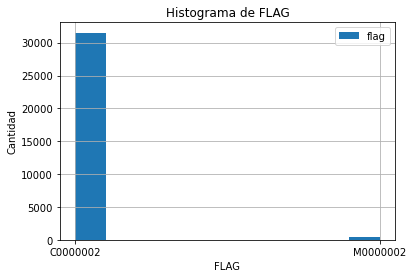

index  Unnamed: 0          nombre    codigo   XO   XA  longitud  latitud  \
0  12502       34485  SANTA CLOTILDE  47271776  548  215 -73.67925 -2.48757   
1   8393       34486  SANTA CLOTILDE  47271776  548  215 -73.67925 -2.48757   

   altura  dato  ...  75%  umb1  umb2          fecha      flag flagV2  \
0   150.0   3.9  ...  4.2   0.6   6.6  2021-04-02-05  C0000002    D01   
1   150.0  15.3  ...  4.2   0.6   6.6  2021-04-02-06  C0000002    D02   

                    imagen clase index_st_group  flag_m2_group  
0  548--215--2021-04-02-10     1     47271776-0              1  
1  548--215--2021-04-02-11     1     47271776-0              1  

[2 rows x 22 columns]

In [32]:
dfLimpioV2024, _dsTrain24, _dsValid24, _dsTest24 = getModelo_DS(dsInit, path_imagenes, p_clas_dud ,comentario=comentarioCLAS_DUD, read=False)
dfLimpioV2024.head(2)

In [33]:
dfLimpioV2024['coods'] = dfLimpioV2024['nombre'] + ': ' +dfLimpioV2024['longitud'].astype(str) + dfLimpioV2024['latitud'].astype(str)

In [34]:
dfLimpioV2024['coods'].unique()

array(['SANTA CLOTILDE: -73.67925-2.48757', 'CUMBA: -78.66413-5.94135',
       'HUALLAPE: -78.69759-5.45077', 'HUANCABAMBA: -79.45399-5.24681',
       'PALCA: -70.59315-15.23587', 'SUMBAY: -71.11667-15.81667',
       'CHIVAY: -71.60169-15.64163',
       'PUENTE SALINAS AMOJAO: -78.4894-5.45096',
       'IMATA: -71.09062-15.84266', 'CASACCANCHA: -72.29832-13.98923',
       'LAGUNILLAS: -70.6775-15.74562', 'PUNO: -70.01208-15.82625',
       'SORAYPAMPA: -72.57419-13.39471', 'SALCCA: -71.23186-14.16994',
       'LA FORTUNA: -78.40242-7.67042', 'UPINA: -70.08281-13.88492',
       'HUASIMO: -80.505-3.99945', 'CHALACO: -79.83-5.03389',
       'HUAYTAPALLANA: -75.06167-11.92667',
       'INTIHUATANA M: -72.5605-13.22431',
       'PUENTE CARRETERA: -69.87381-15.25544',
       'TINGO MARIA: -76.00207-9.29601', 'PUENTE BELLA: -76.02778-9.32',
       'CUTERVO GORE: -78.81339-6.37914',
       'CORACHAY II: -70.28831-17.11413', 'PIRCA: -76.65514-11.23284',
       'SALIDA TUNEL KOVIRE: -70.00949-17.

In [40]:
temp =  dfLimpioV2024[dfLimpioV2024['dato']<=1]
print(len(temp[temp['dato']>1]), len(temp[temp['dato']<1]))
temp.groupby('flag').count()[['dato']] / len(temp)

0 18503


dato
flag              
C0000002  0.981512
M0000002  0.018488

In [41]:
temp =  dfLimpioV2024[dfLimpioV2024['dato']>1]
print(len(temp[temp['dato']>1]), len(temp[temp['dato']<1]))
temp.groupby('flag').count()[['dato']] / len(temp)

12542 0


dato
flag              
C0000002  0.988758
M0000002  0.011242

In [42]:
temp =  dfLimpioV2024
print(len(temp[temp['dato']>1]), len(temp[temp['dato']<1]))
temp.groupby('flag').count()[['dato']] / len(temp)

12542 18503


dato
flag              
C0000002  0.984351
M0000002  0.015649

In [ ]:
12,623  18,785

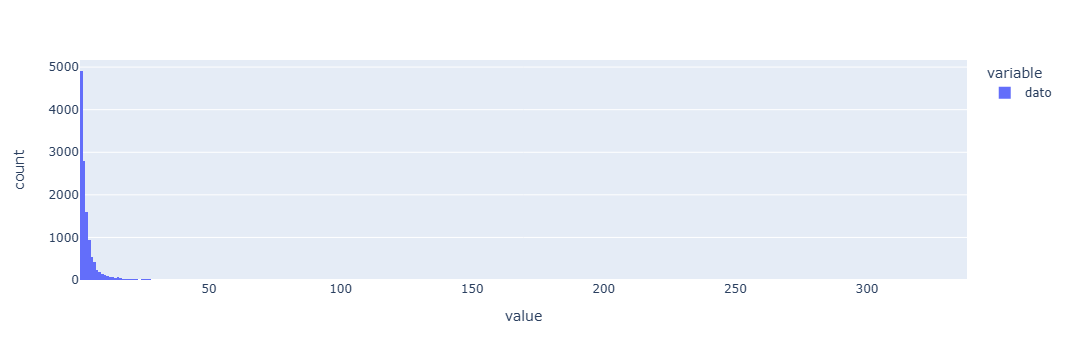

In [23]:
import plotly.express as px
temp = dfLimpioV2024[dfLimpioV2024['dato']>1]
px.histogram(temp['dato'])

In [44]:
dfLimpioV2024[(dfLimpioV2024['dato']>0)&(dfLimpioV2024['dato']<1)].groupby(['flag','flagV2']).count()[['dato']]


dato
flag     flagV2       
C0000002 C01       892
         D01      8362
         D02     10076
M0000002 C01       244
         D01       213
         D02       134

In [47]:
dfLimpioV2024[(dfLimpioV2024['dato']>0)&(dfLimpioV2024['dato']<1)].groupby(['flag','flagV2']).count()[['dato']]


dato
flag     flagV2       
C0000002 D01      8362
         D02     10076
M0000002 D01       213
         D02       134

Tamaño:  32376
Estaciones:  153


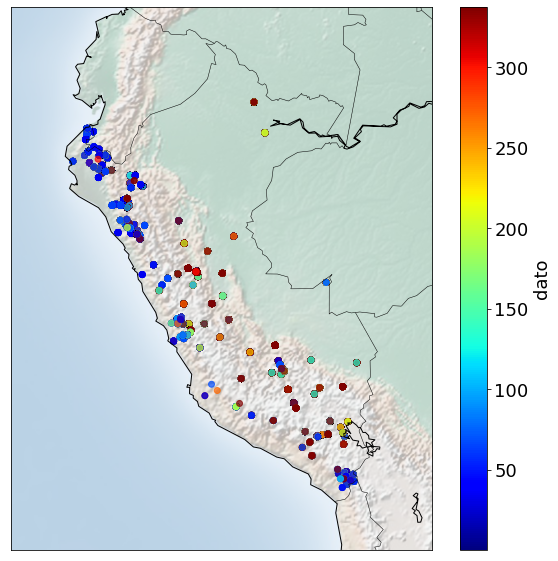

In [50]:
graficar(dfLimpioV2024)

In [2]:
raise exeption 

NameError: name 'exeption' is not defined

In [17]:
import pandas as pd
import os
df = pd.read_csv(listDataset[0])#[cols]

#data_grouped = data.groupby(['codigo', 'flag']).count()[['dato']].reset_index()
#df2 = data_grouped.merge(df[['codigo', 'longitud', 'latitud']].drop_duplicates(), on='codigo', how='left')

In [21]:
df[(df['dato']>0)&(df['dato']<1)].groupby(['flag','flagV2']).count()[['dato']]

dato
flag     flagV2       
C0000002 C01       892
         D01      8362
         D02     10076
M0000002 C01       244
         D01       213
         D02       134

In [100]:
df = pd.read_csv(listDataset[0])
data = df[(df['dato']>1)&(df['flagV2'].isin(['D01', 'D02']))]
data_grouped = data.groupby(['codigo', 'flag']).count()[['dato']].reset_index()
df2 = data_grouped.merge(df[['codigo', 'longitud', 'latitud']].drop_duplicates(), on='codigo', how='left')
df2

codigo      flag  dato  longitud   latitud
0      107131  C0000002   197 -78.40242  -7.67042
1      109091  C0000002    53 -77.75173  -9.04586
2      109093  C0000002   139 -74.94356 -10.28619
3      110137  C0000002   102 -76.52927 -10.60641
4      110138  C0000002    17 -77.52504 -10.07116
..        ...       ...   ...       ...       ...
164  47E89394  C0000002    89 -77.40607  -9.85243
165  47E8B578  C0000002   130 -71.01823 -13.92214
166  47E9177A  C0000002    10 -80.16707  -4.29909
167  47E9177A  M0000002     1 -80.16707  -4.29909
168  47E94706  C0000002   104 -78.96319  -6.45364

[169 rows x 5 columns]

In [51]:
dfLimip = pd.read_csv(listDataset[0])
dfLimip = dfLimip[(dfLimip['codigo'].isin(dfTotal['codigo']))]

In [52]:
dfLeve = pd.read_csv(listDataset[0])
dfLeve = dfLeve[(dfLeve['dato']<1)&(dfLeve['dato']>0)&(dfLeve['flagV2'].isin(['D01', 'D02']))]

In [54]:
dfEstts = pd.concat([dfLimip.groupby(['codigo']).count()[['dato']],dfTotal.groupby(['codigo']).count()[['dato']]], axis=1)
dfEstts.columns=['cant_total', 'cant_usada']
dfEstts['Excludio'] = dfEstts['cant_total'] - dfEstts['cant_usada']
dfEstts['%Excludio'] = (dfEstts['cant_total'] - dfEstts['cant_usada'])/dfEstts['cant_total']
dfEstts = dfEstts[~dfEstts.index.isin(['47E22148'])]

In [62]:
dfEstts

cant_total  cant_usada  Excludio  %Excludio
codigo                                               
107131          1073          48      1025   0.955266
109091           249          36       213   0.855422
109093           219          41       178   0.812785
110137           249          31       218   0.875502
110138            66           9        57   0.863636
...              ...         ...       ...        ...
47E880E2         275          37       238   0.865455
47E89394         357          33       324   0.907563
47E8B578         286          28       258   0.902098
47E9177A          85          10        75   0.882353
47E94706         430          26       404   0.939535

[128 rows x 4 columns]

In [55]:
df = dfEstts.reset_index().merge(dfLimip[['codigo', 'longitud', 'latitud']].drop_duplicates(), on='codigo', how='left')

<AxesSubplot:>

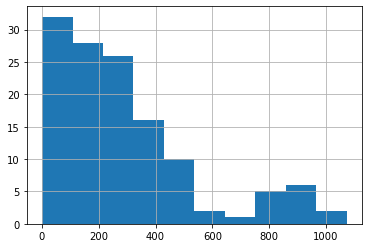

In [71]:
dfEstts['Excludio'].hist()

In [73]:
df['dato'] =  df['%Excludio']

Tamaño:  128
Estaciones:  128


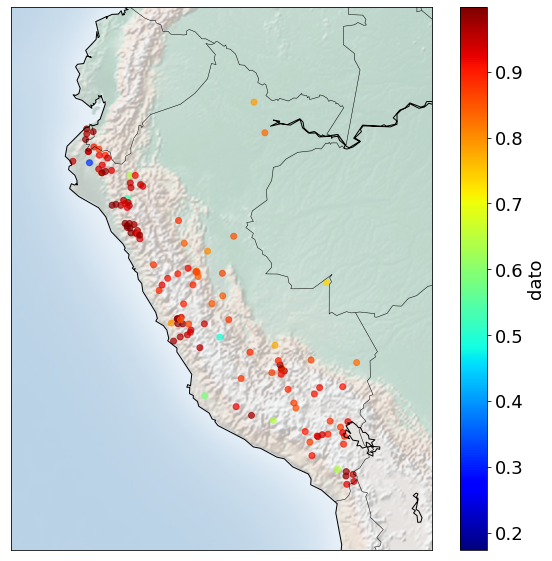

In [74]:
graficar(df)

Tamaño:  18785
Estaciones:  151


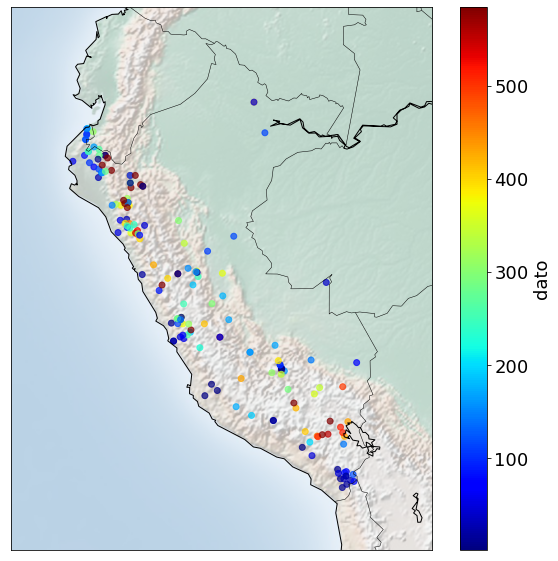

Tamaño:  347
Estaciones:  17


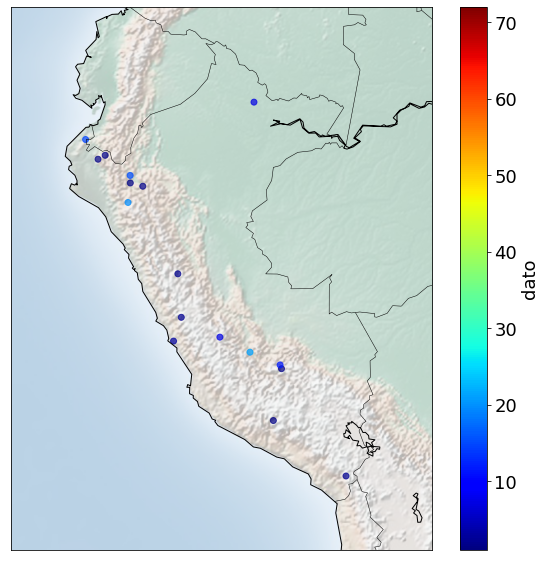

Tamaño:  18438
Estaciones:  150


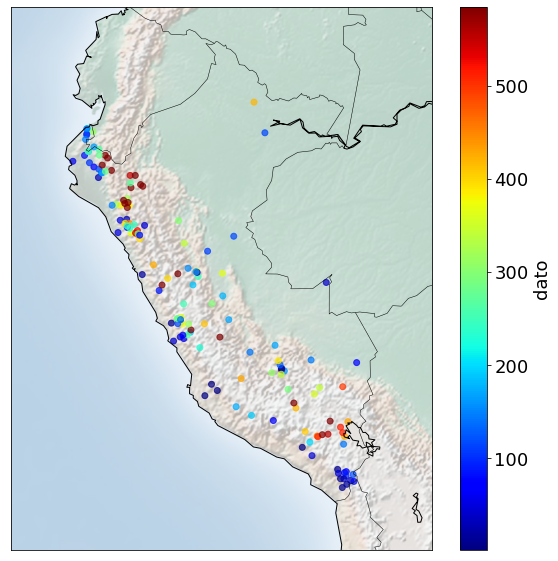

In [59]:
dfLeve = pd.read_csv(listDataset[0])
dfLeve = dfLeve[(dfLeve['dato']<1)&(dfLeve['dato']>0)&(dfLeve['flagV2'].isin(['D01', 'D02']))]
graficar(dfLeve)
graficar(dfLeve[dfLeve['flag']=='M0000002'])
graficar(dfLeve[dfLeve['flag']=='C0000002'])

Tamaño:  1274
Estaciones:  100


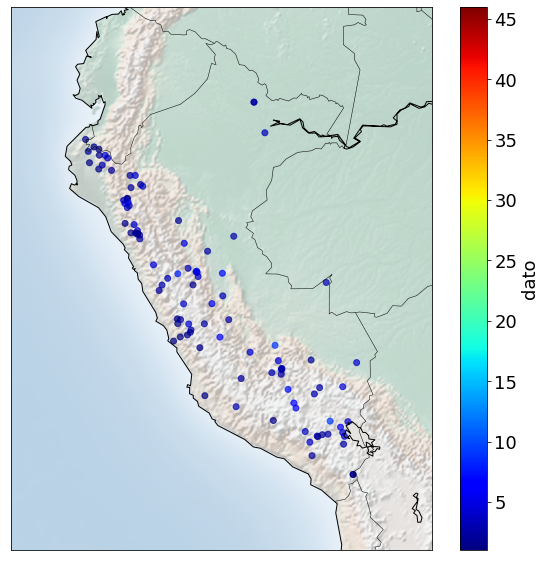

Tamaño:  12
Estaciones:  5


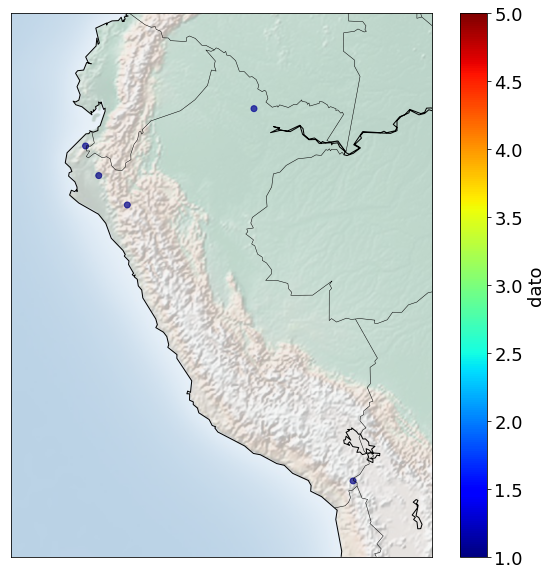

Tamaño:  1262
Estaciones:  98


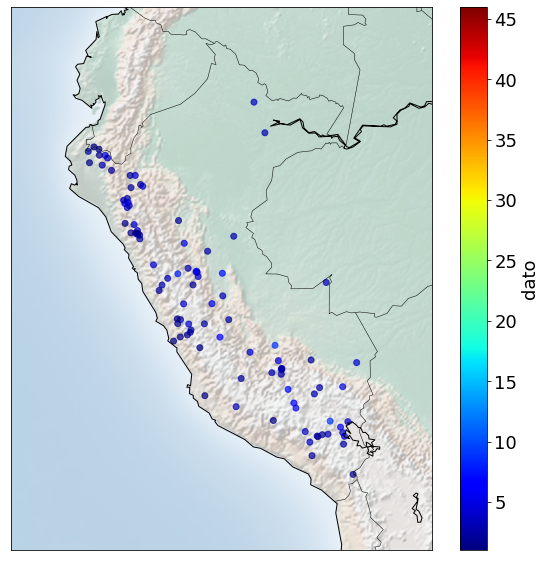

In [137]:
graficar(dftest)
graficar(dftest[dftest['flag']=='M0000002'])
graficar(dftest[dftest['flag']=='C0000002'])

Tamaño:  1293
Estaciones:  103


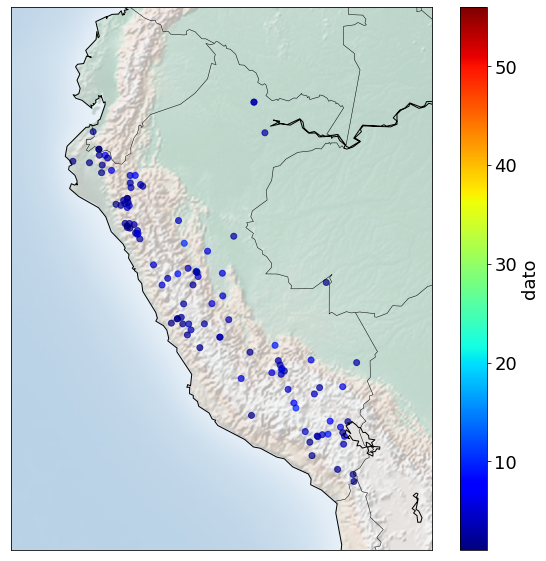

Tamaño:  12
Estaciones:  5


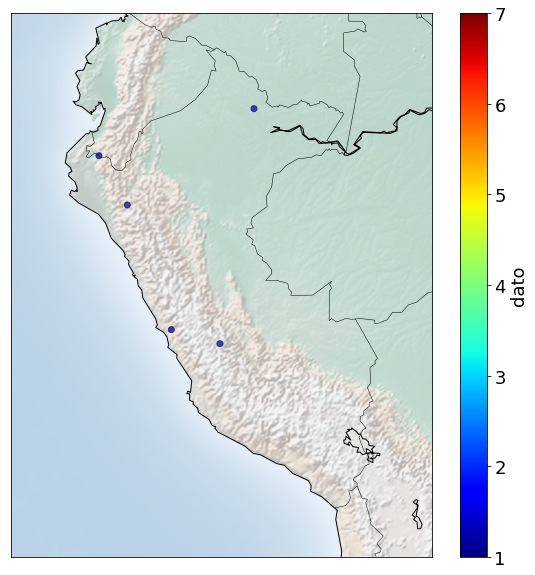

Tamaño:  1281
Estaciones:  102


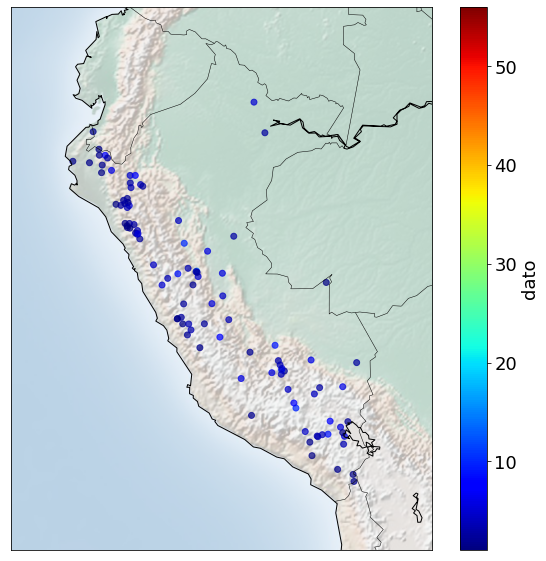

In [138]:
graficar(dfval)
graficar(dfval[dfval['flag']=='M0000002'])
graficar(dfval[dfval['flag']=='C0000002'])

Tamaño:  1920
Estaciones:  113


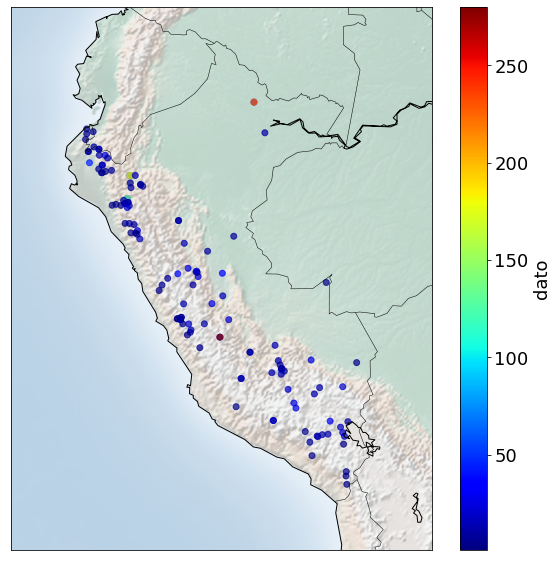

Tamaño:  960
Estaciones:  21


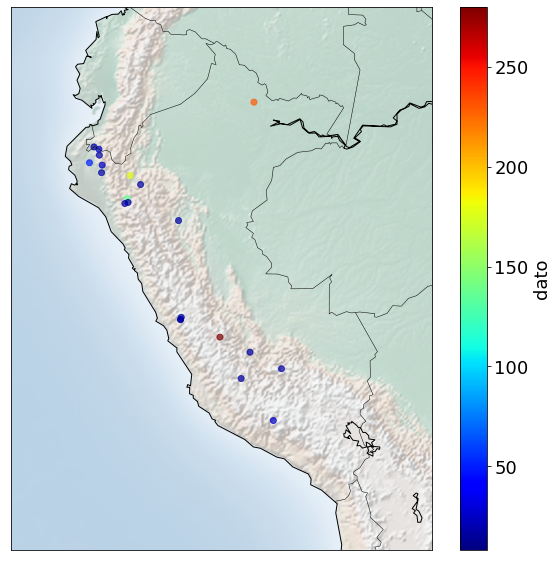

Tamaño:  960
Estaciones:  108


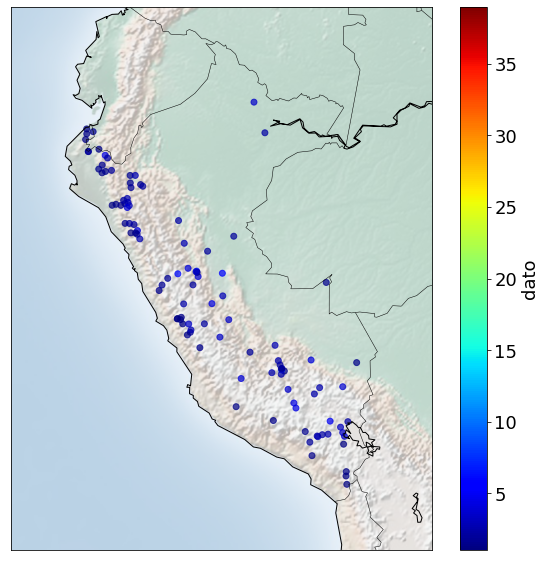

In [139]:
graficar(dftrain)
graficar(dftrain[dftrain['flag']=='M0000002'])
graficar(dftrain[dftrain['flag']=='C0000002'])

In [128]:
dfFalta = dfLeve[~dfLeve['codigo'].isin(dfTotal['codigo'].unique())]

Tamaño:  433
Estaciones:  22


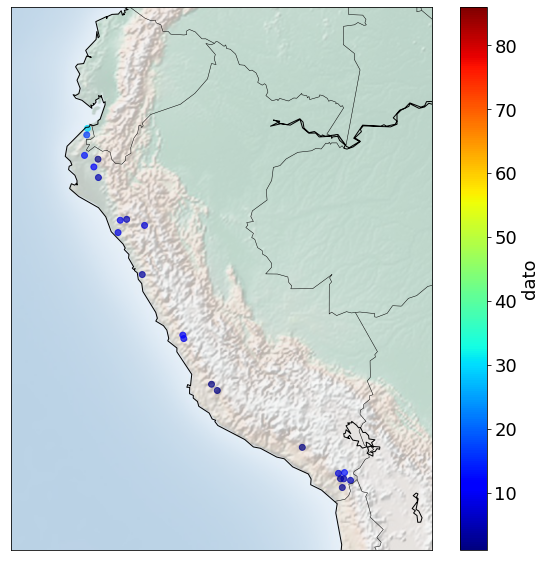

Tamaño:  1
Estaciones:  1


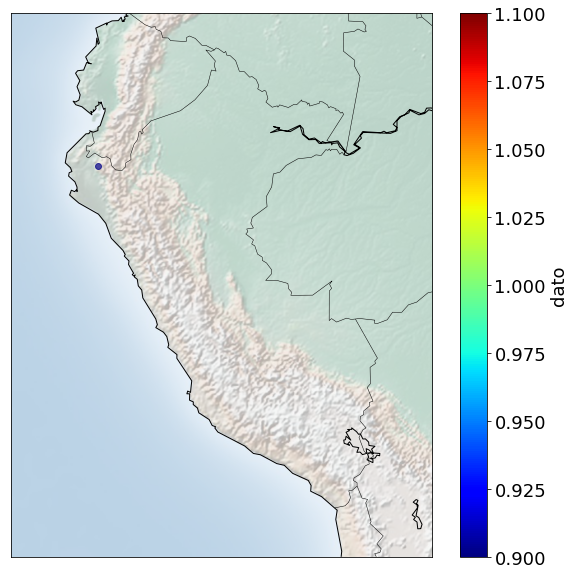

Tamaño:  432
Estaciones:  21


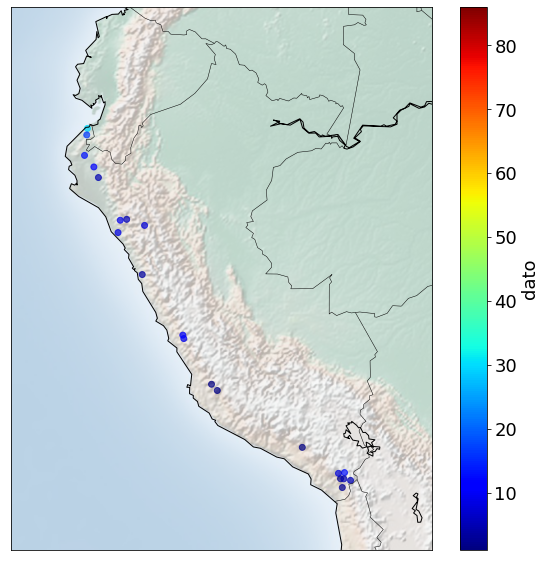

In [140]:
graficar(dfFalta)
graficar(dfFalta[dfFalta['flag']=='M0000002'])
graficar(dfFalta[dfFalta['flag']=='C0000002'])

In [12]:
dftest = pd.read_csv('C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/FinalTesis/Tesis2-DiegoParedes/Archivos/Dataset/Clasificacion/Pruebas/ClaseV7_PruebasDS.csv')
dfval = pd.read_csv('C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/FinalTesis/Tesis2-DiegoParedes/Archivos/Dataset/Clasificacion/Validacion/ClaseV7_ValidacionDS.csv')
dftrain = pd.read_csv('C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/FinalTesis/Tesis2-DiegoParedes/Archivos/Dataset/Clasificacion/Entrenamiento/V7_SplitCon_DA4/CLASE_TrainDS_1.csv')

In [17]:
dfTotal = pd.concat([dftest,dfval,dftrain])

Tamaño:  4487
Estaciones:  129


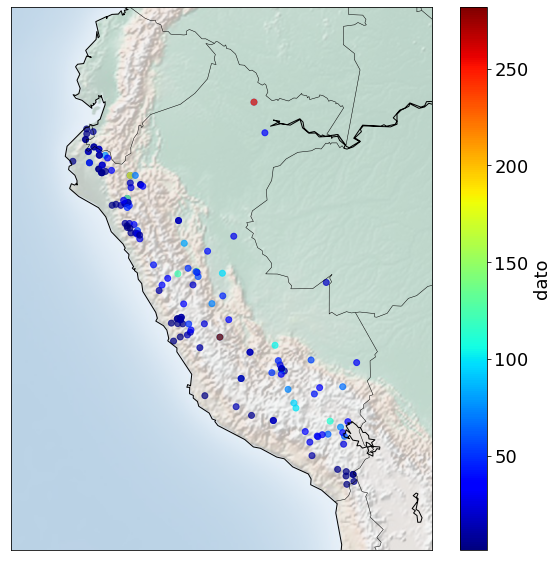

Tamaño:  984
Estaciones:  25


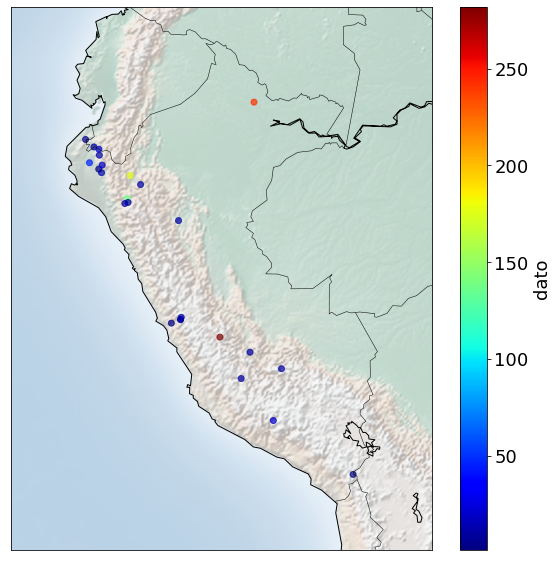

Tamaño:  3503
Estaciones:  127


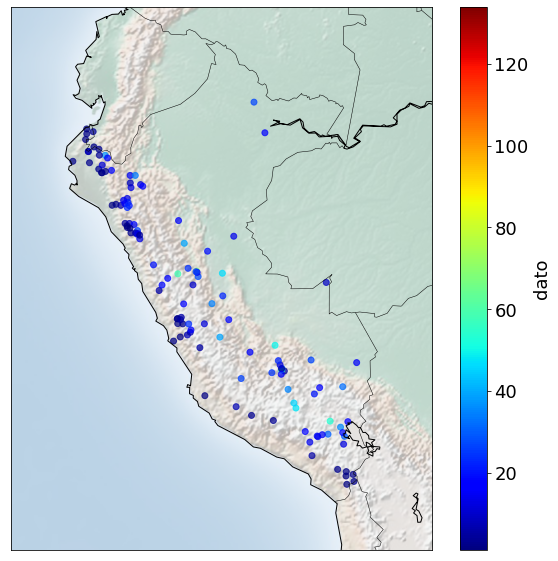

In [141]:
graficar(dfTotal)
graficar(dfTotal[dfTotal['flag']=='M0000002'])
graficar(dfTotal[dfTotal['flag']=='C0000002'])

In [48]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

def graficar(dfbase):
    #data = df#[(df['dato']<1)&(df['dato']>0)&(df['flagV2'].isin(['D01', 'D02']))]
    print('Tamaño: ', len(dfbase))
    print('Estaciones: ', dfbase['codigo'].nunique())
    #data_grouped = dfbase.groupby(['codigo', 'flag']).count()[['dato']].reset_index()
    #df = data_grouped.merge(dfbase[['codigo', 'longitud', 'latitud']].drop_duplicates(), on='codigo', how='left')
    # Crear figura con tamaño personalizado
    plt.figure(figsize=(10, 10))

    # Crear el mapa del Perú
    mapa = Basemap(llcrnrlon=-83.54, llcrnrlat=-20.22, urcrnrlon=-66.45, urcrnrlat=1.38, resolution='l', projection='merc')

    # Dibujar la costa
    mapa.drawcoastlines()

    # Dibujar los límites de los países
    mapa.drawcountries()

    # Asignar colores a los puntos en función de una columna del DataFrame
    colores = plt.cm.jet(df['dato'].values)  # Ajusta 'Columna' al nombre de la columna que contiene los valores entre 0 y 1

    # Dibujar puntos en el mapa con tamaño reducido y colores asignados
    mapa.scatter(df['longitud'], df['latitud'],  c=colores, marker='o', alpha=0.7, label='Puntos', latlon=True)

    # Ajustar el tamaño del mapa
    #plt.xlim(-90, -60)
    #plt.ylim(-25, 5)

    # Añadir sombreado de relieve
    mapa.shadedrelief(alpha=0.5)  # Puedes ajustar el valor de alpha según lo que necesites

    # Crear un objeto ScalarMappable para la leyenda del color
    sm = ScalarMappable(cmap=plt.cm.jet)
    sm.set_array(df['dato'])  # Ajusta 'Columna' al nombre de la columna que contiene los valores entre 0 y 1

    # Añadir la leyenda del color
    cbar = plt.colorbar(sm)
    cbar.set_label('dato')
    cbar.ax.tick_params(labelsize=18) 
    cbar.ax.yaxis.label.set_size(18)
    # Mostrar el mapa
    plt.show()

    

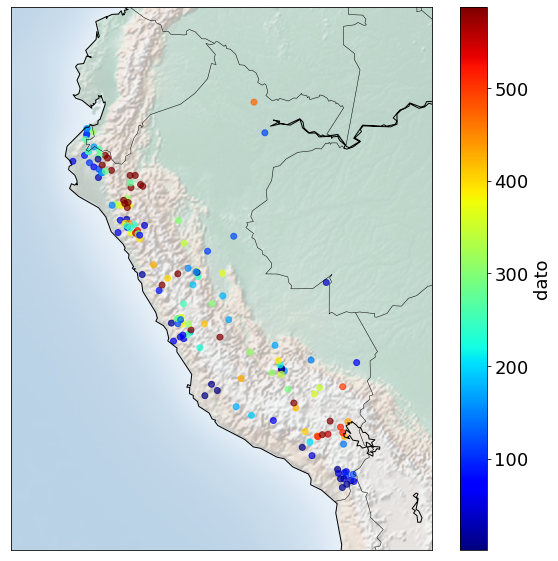

In [80]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable

# Crear figura con tamaño personalizado
plt.figure(figsize=(10, 10))

# Crear el mapa del Perú
mapa = Basemap(llcrnrlon=-83.54, llcrnrlat=-20.22, urcrnrlon=-66.45, urcrnrlat=1.38, resolution='l', projection='merc')

# Dibujar la costa
mapa.drawcoastlines()

# Dibujar los límites de los países
mapa.drawcountries()

# Asignar colores a los puntos en función de una columna del DataFrame
colores = plt.cm.jet(df2['dato'].values)  # Ajusta 'Columna' al nombre de la columna que contiene los valores entre 0 y 1

# Dibujar puntos en el mapa con tamaño reducido y colores asignados
mapa.scatter(df2['longitud'], df2['latitud'],  c=colores, marker='o', alpha=0.7, label='Puntos', latlon=True)

# Ajustar el tamaño del mapa
#plt.xlim(-90, -60)
#plt.ylim(-25, 5)

# Añadir sombreado de relieve
mapa.shadedrelief(alpha=0.5)  # Puedes ajustar el valor de alpha según lo que necesites

# Crear un objeto ScalarMappable para la leyenda del color
sm = ScalarMappable(cmap=plt.cm.jet)
sm.set_array(df2['dato'])  # Ajusta 'Columna' al nombre de la columna que contiene los valores entre 0 y 1

# Añadir la leyenda del color
cbar = plt.colorbar(sm)
cbar.set_label('dato')
cbar.ax.tick_params(labelsize=18) 
cbar.ax.yaxis.label.set_size(18)
# Mostrar el mapa
plt.show()


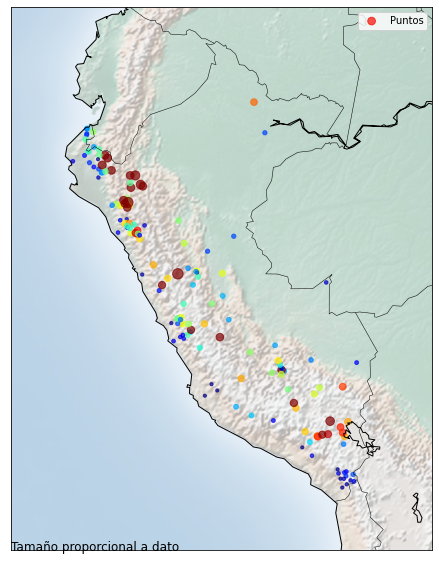

In [79]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
import numpy as np

# Crear figura con tamaño personalizado
plt.figure(figsize=(10, 10))

# Crear el mapa del Perú
mapa = Basemap(llcrnrlon=-83.54, llcrnrlat=-20.22, urcrnrlon=-66.45, urcrnrlat=1.38, resolution='l', projection='merc')

# Dibujar la costa
mapa.drawcoastlines()

# Dibujar los límites de los países
mapa.drawcountries()

# Escalar el tamaño de los puntos en función de la columna 'dato'
# Normalizar el tamaño de los puntos para que estén en un rango razonable
sizes = 100 * (df2['dato'] - df2['dato'].min()) / (df2['dato'].max() - df2['dato'].min()) + 10  # Rango de tamaño [10, 110]
colores = plt.cm.jet(df2['dato'].values)
# Dibujar puntos en el mapa con tamaño variable y colores por defecto (o un único color si se prefiere)
mapa.scatter(df2['longitud'], df2['latitud'], c=colores, s=sizes, marker='o', alpha=0.7, label='Puntos', latlon=True)

# Añadir sombreado de relieve
mapa.shadedrelief(alpha=0.5)  # Puedes ajustar el valor de alpha según lo que necesites

# Crear una leyenda de tamaño personalizada si se desea
# Aquí simplemente se crea un ejemplo de tamaño de punto
plt.legend(loc='upper right')
plt.text(-80, -15, 'Tamaño proporcional a dato', fontsize=12)

# Mostrar el mapa
plt.show()


In [15]:
df_temp[df_temp['codigo']=='47271776'].groupby('flag').max()

Unnamed: 0          nombre    codigo   XO   XA  longitud  latitud  \
flag                                                                          
C0000002       50032  SANTA CLOTILDE  47271776  548  215 -73.67925 -2.48757   
M0000002       50060  SANTA CLOTILDE  47271776  548  215 -73.67925 -2.48757   

          altura  dato  90%    99%  75%  umb1  umb2          fecha flagV2  \
flag                                                                        
C0000002   150.0  31.2  0.3  9.936  0.0   0.6   6.6  2021-09-01-18    D02   
M0000002   150.0  35.7  0.3  9.936  0.0   0.6   6.6  2021-10-31-23    D02   

                           imagen  
flag                               
C0000002  548--215--2021-09-01-18  
M0000002  548--215--2021-10-31-23

In [16]:
df_goods = df_temp[df_temp['flag']=='C0000002']
df_goods.groupby('flagV2').count()

Unnamed: 0  nombre  codigo     XO     XA  longitud  latitud  altura  \
flagV2                                                                        
C01           8588    8588    8588   8588   8588      8588     8588    8588   
D01          11544   11544   11544  11544  11544     11544    11544   11544   
D02          20336   20336   20336  20336  20336     20336    20336   20336   

         dato    90%    99%    75%   umb1   umb2  fecha   flag  imagen  
flagV2                                                                  
C01      8588   8588   8588   8588   8588   8588   8588   8588    8588  
D01     11544  11544  11544  11544  11544  11544  11544  11544   11544  
D02     20336  20336  20336  20336  20336  20336  20336  20336   20336

In [17]:
df_bads = df_temp[df_temp['flag']=='M0000002']
df_bads['codigo'].nunique()

34

In [18]:
df_bads.groupby('flagV2').count()

Unnamed: 0  nombre  codigo    XO    XA  longitud  latitud  altura  \
flagV2                                                                      
C01           2306    2306    2306  2306  2306      2306     2306    2306   
D01            238     238     238   238   238       238      238     238   
D02            258     258     258   258   258       258      258     258   

        dato   90%   99%   75%  umb1  umb2  fecha  flag  imagen  
flagV2                                                           
C01     2306  2306  2306  2306  2306  2306   2306  2306    2306  
D01      238   238   238   238   238   238    238   238     238  
D02      258   258   258   258   258   258    258   258     258

In [19]:
df_bads_c1 = df_bads[df_bads['flagV2']=='C01']

In [20]:
df_bads_c1.groupby('dato').count()

Unnamed: 0  nombre  codigo    XO    XA  longitud  latitud  altura   90%  \
dato                                                                            
0.0         2062    2062    2062  2062  2062      2062     2062    2062  2062   
0.1          158     158     158   158   158       158      158     158   158   
0.2           77      77      77    77    77        77       77      77    77   
0.3            3       3       3     3     3         3        3       3     3   
0.4            3       3       3     3     3         3        3       3     3   
0.5            2       2       2     2     2         2        2       2     2   
0.6            1       1       1     1     1         1        1       1     1   

       99%   75%  umb1  umb2  fecha  flag  flagV2  imagen  
dato                                                       
0.0   2062  2062  2062  2062   2062  2062    2062    2062  
0.1    158   158   158   158    158   158     158     158  
0.2     77    77    77    77     77    77      77      77  
0.3      3     3     3     3      3     3       3       3  
0.4      3     3     3     3      3     3       3       3  
0.5      2     2     2     2      2     2       2       2  
0.6      1     1     1     1      1     1       1       1

In [21]:
df_bads_c1.groupby(['dato','codigo']).count()

Unnamed: 0  nombre   XO   XA  longitud  latitud  altura  90%  \
dato codigo                                                                   
0.0  47271776         570     570  570  570       570      570     570  570   
     472935F2         179     179  179  179       179      179     179  179   
     4729658E         745     745  745  745       745      745     745  745   
     472F43AC         144     144  144  144       144      144     144  144   
     47E1F02E         424     424  424  424       424      424     424  424   
0.1  472F43AC          96      96   96   96        96       96      96   96   
     47E1F02E          16      16   16   16        16       16      16   16   
     47E880E2          46      46   46   46        46       46      46   46   
0.2  472935F2          26      26   26   26        26       26      26   26   
     4729658E          40      40   40   40        40       40      40   40   
     472F43AC          10      10   10   10        10       10      10   10   
     47E880E2           1       1    1    1         1        1       1    1   
0.3  472F43AC           3       3    3    3         3        3       3    3   
0.4  472935F2           1       1    1    1         1        1       1    1   
     4729658E           1       1    1    1         1        1       1    1   
     472F43AC           1       1    1    1         1        1       1    1   
0.5  472F43AC           2       2    2    2         2        2       2    2   
0.6  472F43AC           1       1    1    1         1        1       1    1   

               99%  75%  umb1  umb2  fecha  flag  flagV2  imagen  
dato codigo                                                       
0.0  47271776  570  570   570   570    570   570     570     570  
     472935F2  179  179   179   179    179   179     179     179  
     4729658E  745  745   745   745    745   745     745     745  
     472F43AC  144  144   144   144    144   144     144     144  
     47E1F02E  424  424   424   424    424   424     424     424  
0.1  472F43AC   96   96    96    96     96    96      96      96  
     47E1F02E   16   16    16    16     16    16      16      16  
     47E880E2   46   46    46    46     46    46      46      46  
0.2  472935F2   26   26    26    26     26    26      26      26  
     4729658E   40   40    40    40     40    40      40      40  
     472F43AC   10   10    10    10     10    10      10      10  
     47E880E2    1    1     1     1      1     1       1       1  
0.3  472F43AC    3    3     3     3      3     3       3       3  
0.4  472935F2    1    1     1     1      1     1       1       1  
     4729658E    1    1     1     1      1     1       1       1  
     472F43AC    1    1     1     1      1     1       1       1  
0.5  472F43AC    2    2     2     2      2     2       2       2  
0.6  472F43AC    1    1     1     1      1     1       1       1

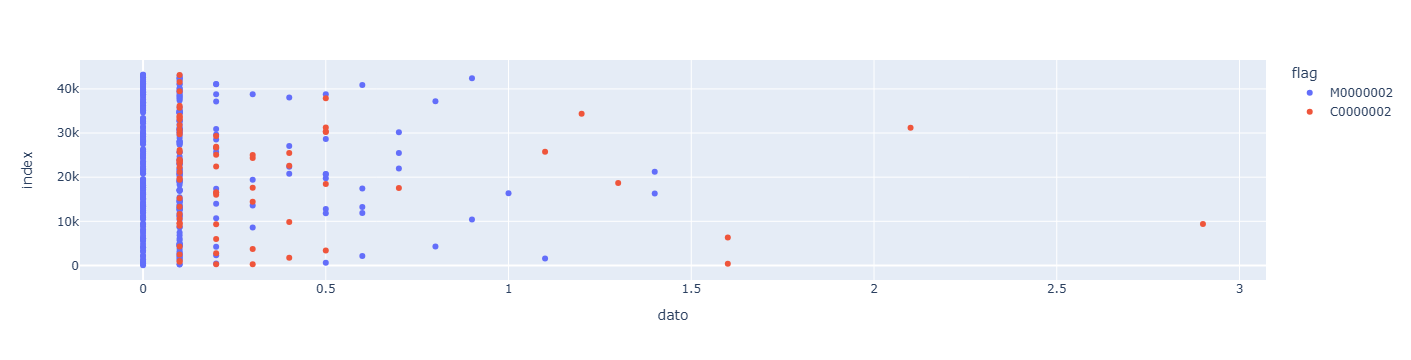

In [51]:
px.scatter(df_temp[df_temp['codigo']=='472F43AC'],x= 'dato', color='flag')

In [22]:
#px.scatter(df_bads_c1, x='dato',y='codigo')

In [23]:
#px.scatter(df_temp.groupby('codigo').max()[['90%']]*10, x='90%')

In [24]:
#df_temp.groupby('codigo').max()[['90%']]

In [25]:
#df_temp[df_temp['90%']<0.1].count()['codigo'] , len(df_temp)

In [26]:
#px.scatter(df_temp.groupby('codigo').mean(), x='umb1')

In [54]:
"""
REGRESION
"""

comentarioCLAS_DUD = 'REGRESION: VFinal - Replica V7 (Var RandomState):  SWAP VAL Y TEST!!'
p_clas_dud = {    
    # parametros del proyecto
    'products'   : products,
    'times'      : times,
    'path_base'  : path_base,

    # parametros del dataset      
    'flags'      : ['C0000002'],
    'flagV2'     : ['D01','D02'],
    'estaciones' : [],
    'ceros'      : False,
    'delete'     : True,
    'menor'      : None,
    'mayor'      : None,
    
    # Split    
    'validacion' : 0.15,#0.1,
    'pruebas'    : 0.176 ,#0.11,
    'random_state' : 50, #5 (m0.1)
    'fixed_hour' : '10', # max 23 hour
    'stratify'   : 'flag_m2_group',
    'index'      : 'index_st_group',
    'niv_prec'   : 6,
    'col_prec'   : 'umb1',
    
    # Modelo
    'redTipo'    : 'Regresion',
    
    # PARA MODELOS DE CLASIFICACION
    'claseName'  : '',
    'condicion_1': [],
    
    # Nombres
    'nameDS'     : 'ClaseV7_Regresion',       
}

In [52]:
100-15

85

In [53]:
15/85


0.17647058823529413

Tipo de dataset: Regresion
Se leera los archivos de datasets...
Tiempo tomado: 0.00s
+Cantidad de datos leidos 43270

Se elimnara los valores nulos y dudosos
Tiempo tomado: 0.02s
+Cantidad de datos luego de elimnar nulos 43270
-------> CANTIDAD FINAL DE DATOS :  31880 <--------------
Tiempo total: 0.03s
Tamaño de los datasets: 
TRAIN   : 22328 - 70.03764115432874 - C0000002    1.0
Name: flag, dtype: float64
VALID   : 4782 - 15.0 - C0000002    1.0
Name: flag, dtype: float64
PRUEBAS : 4770  - 14.962358845671266 - C0000002    1.0
Name: flag, dtype: float64
           ESTADISCIAS DEL ClaseV7_Regresion 

Flags       : ['C0000002']
Estaciones  : 152
Totales     : 31880
Ceros       : 0
Menor a 1   : 18438
Mayor a 1   : 12479
Maximo      : 66.9
Media       : 1.714586574654956
STD         : 3.239799968338469


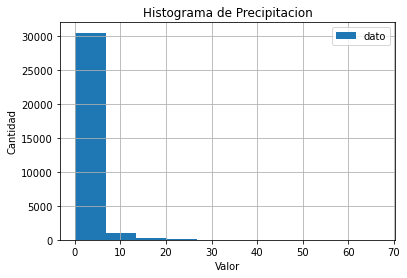

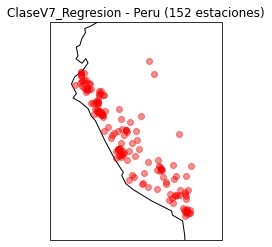

Unnamed: 0        nombre    codigo   XO   XA  longitud   latitud  \
5121        19022  CRUCERO ALTO  47E3903C  701  951 -70.91100 -15.76448   
33876        1910    CAPACHIQUE  472EB1D2  291  513 -78.31184  -7.85642   

       altura  dato  90%  99%  75%  umb1  umb2          fecha      flag  \
5121   4511.0   0.6  0.0  1.1  0.0   2.2   5.1  2021-03-22-13  C0000002   
33876  2904.0   0.2  0.0  1.2  0.0   5.0   8.7  2021-11-17-05  C0000002   

      flagV2                   imagen  
5121     D02  701--951--2021-03-22-13  
33876    D02  291--513--2021-11-17-05

In [55]:
dfLimpioCLAS_DUD, _dsTrain, _dsValid, _dsTest = getModelo_DS(dsInit, path_imagenes, p_clas_dud ,comentario=comentarioCLAS_DUD, read=False)
dfLimpioCLAS_DUD.head(2)

In [153]:
"""
Clasificacion
"""
comentarioCLAS_DUD = 'VFinal - Replica V7 (Var RandomState):  SWAP VAL Y TEST!!'
p_clas_dud = {    
    # parametros del proyecto
    'products'   : products,
    'times'      : times,
    'path_base'  : path_base,

    # parametros del dataset      
    'flags'      : ['C0000002','M0000002'],
    'flagV2'     : ['D01','D02','C01'],
    'estaciones' : [],
    'ceros'      : False,
    'delete'     : True,
    'menor'      : None,
    'mayor'      : None,
    
    # Split    
    'validacion' : 0.1,
    'pruebas'    : 0.11,
    'random_state' : 50, #5 (m0.1)
    'fixed_hour' : '10', # max 23 hour
    'stratify'   : 'flag_m2_group',
    'index'      : 'index_st_group',
    'niv_prec'   : 6,
    'col_prec'   : 'umb1',
    
    # Modelo
    'redTipo'    : 'Clasificacion',
    
    # PARA MODELOS DE CLASIFICACION
    'claseName'  : 'clase',
    'condicion_1': ['flag','C0000002'],    
    
    # Nombres
    'nameDS'     : 'ClaseVFinal_M0',       
}

In [20]:
dsInit = pd.read_csv(listDataset[0])

In [154]:
# -TODOO Quitamos C01 con C00000002
dsInit = pd.read_csv(listDataset[0])
dsInit = dsInit[~((dsInit['flag'].isin(['C0000002']))&(dsInit['flagV2'].isin(['C01'])))]

In [155]:
dsInit.groupby(['flag','flagV2']).count()

Unnamed: 0  nombre  codigo     XO     XA  longitud  latitud  \
flag     flagV2                                                                
C0000002 D01          11544   11544   11544  11544  11544     11544    11544   
         D02          20336   20336   20336  20336  20336     20336    20336   
M0000002 C01           2306    2306    2306   2306   2306      2306     2306   
         D01            238     238     238    238    238       238      238   
         D02            258     258     258    258    258       258      258   

                 altura   dato    90%    99%    75%   umb1   umb2  fecha  \
flag     flagV2                                                            
C0000002 D01      11544  11544  11544  11544  11544  11544  11544  11544   
         D02      20336  20336  20336  20336  20336  20336  20336  20336   
M0000002 C01       2306   2306   2306   2306   2306   2306   2306   2306   
         D01        238    238    238    238    238    238    238    238   
         D02        258    258    258    258    258    258    258    258   

                 imagen  
flag     flagV2          
C0000002 D01      11544  
         D02      20336  
M0000002 C01       2306  
         D01        238  
         D02        258

In [150]:
#dsInit[(dsInit['dato']<1)&(dsInit['flag']=='M0000002')].groupby('dato').count()

Tipo de dataset: Clasificacion
Se leera los archivos de datasets...
Tiempo tomado: 0.00s
+Cantidad de datos leidos 34682

Se elimnara los valores nulos y dudosos
Tiempo tomado: 0.02s
+Cantidad de datos luego de elimnar nulos 34682
-------> CANTIDAD FINAL DE DATOS :  32620 <--------------
Tiempo total: 0.04s
Tamaño de los datasets: 
TRAIN   : 26308 - 80.64990803188228 - C0000002    0.976661
M0000002    0.023339
Name: flag, dtype: float64
VALID   : 3211 - 9.843654199877376 - C0000002    0.978823
M0000002    0.021177
Name: flag, dtype: float64
PRUEBAS : 3101  - 9.506437768240342 - C0000002    0.981296
M0000002    0.018704
Name: flag, dtype: float64
           ESTADISCIAS DEL ClaseVFinal_M0 

Flags       : ['C0000002' 'M0000002']
Estaciones  : 153
Totales     : 32620
Ceros       : 0
Clase 0(M02): 2.2685469037400368 - 740
Clase 1(C02): 97.73145309625997 - 31880
Maximo      : 337.5
Media       : 1.9167084610668301
STD         : 8.238564165577053


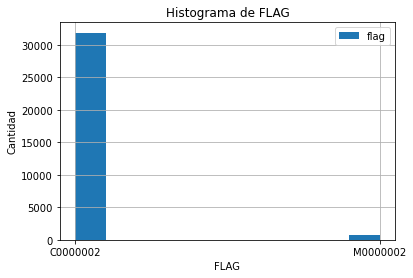

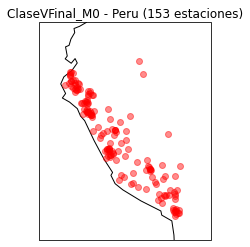

index  Unnamed: 0     nombre    codigo   XO   XA  longitud  latitud  \
0   7211        4993  CACHICOTO  47E845FC  400  586 -76.35028 -9.18361   
1  33805        7685  CACHICOTO  47E845FC  400  586 -76.35028 -9.18361   

   altura  dato  ...  75%  umb1  umb2          fecha      flag flagV2  \
0  1109.0   3.6  ...  0.0   5.5  28.6  2021-02-16-21  C0000002    D02   
1  1109.0  15.0  ...  0.0   5.5  28.6  2021-02-16-22  C0000002    D02   

                    imagen clase index_st_group  flag_m2_group  
0  400--586--2021-02-16-21     1     47E845FC-0              0  
1  400--586--2021-02-16-22     1     47E845FC-0              0  

[2 rows x 22 columns]

In [156]:
dfLimpioCLAS_DUD, _dsTrain, _dsValid, _dsTest = getModelo_DS(dsInit, path_imagenes, p_clas_dud ,comentario=comentarioCLAS_DUD, read=False)
dfLimpioCLAS_DUD.head(2)

OSError: exception: access violation reading 0x0000000000000010

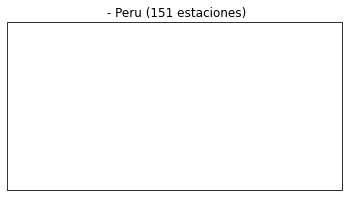

In [13]:
#import numpy as np
listDataset
df = pd.read_csv(listDataset[0])
visualizarEstaciones(df[(df['dato']<1)&(df['dato']>0)])

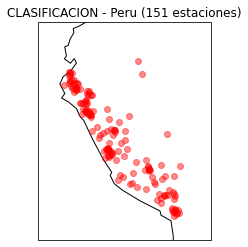

In [18]:
import pandas as pd

visualizarEstaciones(df_temp[~df_temp['codigo'].isin(['47E1F02E','47251282'])], name = 'CLASIFICACION',imagenTest='')

In [16]:
df_temp[~df_temp['codigo'].isin(['47E1F02E','47251282'])]

NameError: name 'codigo' is not defined

           ESTADISCIAS DEL ds 

Flags       : ['C0000002' 'M0000002']
Estaciones  : 151
Totales     : 26308
Ceros       : 0
Clase 0(M02): 2.3338908316861793 - 614
Clase 1(C02): 97.66610916831382 - 25694
Maximo      : 337.5
Media       : 1.8983320662916223
STD         : 8.021763744019845


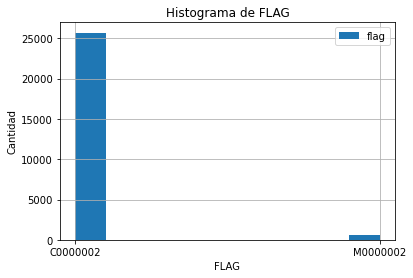

In [157]:
statsDS(_dsTrain, name='ds', tipo='Clasificacion')

           ESTADISCIAS DEL ds 

Flags       : ['C0000002' 'M0000002']
Estaciones  : 130
Totales     : 3211
Ceros       : 0
Clase 0(M02): 2.117720336343818 - 68
Clase 1(C02): 97.88227966365618 - 3143
Maximo      : 310.8
Media       : 1.9396947991279976
STD         : 9.319314711828367


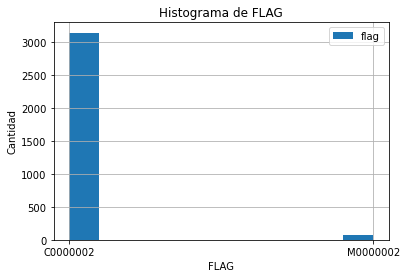

In [158]:
statsDS(_dsValid, name='ds', tipo='Clasificacion')

           ESTADISCIAS DEL ds 

Flags       : ['C0000002' 'M0000002']
Estaciones  : 136
Totales     : 3101
Ceros       : 0
Clase 0(M02): 1.870364398581103 - 58
Clase 1(C02): 98.1296356014189 - 3043
Maximo      : 310.8
Media       : 2.0488068365043537
STD         : 8.841014329948417


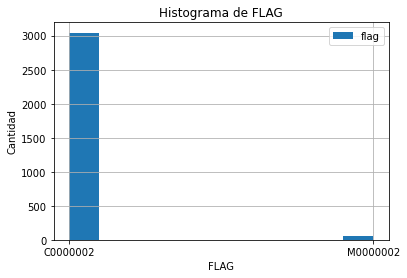

In [159]:
statsDS(_dsTest, name='ds', tipo='Clasificacion')

In [72]:
#px.scatter(_dsTrain, x='dato',y='codigo', color='flag')

In [2]:
import pandas as pd
#df_v7 = pd.read_csv('C:/Users/Shounen/Desktop/Ciclo XI/Tesis 2/FinalTesis/Tesis2-DiegoParedes/Archivos/Dataset/Clasificacion/ClaseV7_CompletoDS.csv')

Unnamed: 0            nombre    codigo   XO   XA   longitud    latitud  \
5           23526             ILLPA  472E4156  747  947 -70.083330 -15.683330   
10          33104             PALCA  472E37C6  719  922 -70.593150 -15.235870   
11          18533        SAN MARTIN  4720EB14  377  598 -76.764820  -9.403850   
14           1124            CIRATO  4724D566  248  446 -79.073842  -6.655825   
18          22814            CIRATO  4724D566  248  446 -79.073842  -6.655825   
...           ...               ...       ...  ...  ...        ...        ...   
43258        7075            TONGOD  47E207A4  263  451 -78.813920  -6.744560   
43259       38897  PUENTE CARRETERA  47251282  759  923 -69.873810 -15.255440   
43266       18415     12 DE OCTUBRE    110137  390  665 -76.529270 -10.606410   
43267       45187            CIRATO  4724D566  248  446 -79.073842  -6.655825   
43269        2750         LARAQUERI  472CB426  750  972 -70.045890 -16.135920   

       altura  dato  90%  99%  75%  umb1  umb2          fecha      flag  \
5      3827.0   0.1  0.0  1.4  0.0   1.0   2.9  2021-12-26-17  C0000002   
10     4073.0   0.5  0.0  2.3  0.0   1.1   4.2  2021-03-15-19  C0000002   
11     3528.0   0.3  0.0  2.1  0.0   1.8   4.1  2021-04-23-20  C0000002   
14      959.0   0.1  0.0  0.9  0.0   0.2   2.3  2021-12-19-22  C0000002   
18      959.0   0.2  0.0  0.9  0.0   0.2   2.3  2021-11-09-08  C0000002   
...       ...   ...  ...  ...  ...   ...   ...            ...       ...   
43258  2488.0   0.3  0.2  5.1  0.0   3.9  10.3  2021-12-06-06  C0000002   
43259  3812.0   0.4  0.0  1.1  0.0   2.6   6.4  2021-01-08-07  C0000002   
43266  3867.0   0.1  0.0  1.8  0.0   2.2   4.6  2021-05-07-19  C0000002   
43267   959.0   0.1  0.0  0.9  0.0   0.2   2.3  2021-09-12-02  C0000002   
43269  3928.0   0.9  0.0  2.9  0.0   3.6  11.1  2021-12-18-16  C0000002   

      flagV2                   imagen  
5        D01  747--947--2021-12-26-17  
10       D01  719--922--2021-03-15-19  
11       D01  377--598--2021-04-23-20  
14       D02  248--446--2021-12-19-22  
18       D02  248--446--2021-11-09-08  
...      ...                      ...  
43258    D01  263--451--2021-12-06-06  
43259    D01  759--923--2021-01-08-07  
43266    C01  390--665--2021-05-07-19  
43267    D02  248--446--2021-09-12-02  
43269    C01  750--972--2021-12-18-16  

[19921 rows x 18 columns]

In [26]:
df[(df['dato']<1)&(df['dato']>0)].groupby(['flag', 'flagV2']).count()[['dato']]

dato
flag     flagV2       
C0000002 C01       892
         D01      8362
         D02     10076
M0000002 C01       244
         D01       213
         D02       134

In [ ]:
df[(df['dato']<1)&(df['dato']>0)].groupby(['flag', 'flagV2']).count()[['dato']]

In [28]:
df[(df['dato']<1)&(df['dato']>0)].groupby(['flag', 'flagV2']).count()[['dato']]

dato
flag     flagV2       
C0000002 C01       892
         D01      8362
         D02     10076
M0000002 C01       244
         D01       213
         D02       134

In [15]:
df_v7['flagV2'].unique()

array(['D02', 'D01'], dtype=object)

           ESTADISCIAS DEL ds_v7 

Flags       : ['C0000002' 'M0000002']
Estaciones  : 146
Totales     : 12623
Ceros       : 0
Clase 0(M02): 1.1407747762021707 - 144
Clase 1(C02): 98.85922522379784 - 12479
Maximo      : 337.5
Media       : 4.3519004990889645
STD         : 12.86890030395137


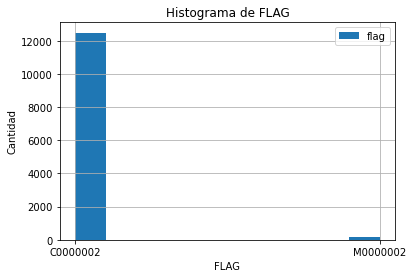

In [16]:
statsDS(df_v7, name='ds_v7', tipo='Clasificacion')

In [18]:
#px.scatter(df_v7, x='dato',y='codigo', color='flag')

In [20]:
#df_v7['dato'].min()

In [23]:
print(df_v7.shape)
print(df_v7.columns)
df_v7.head()

(12623, 19)
Index(['Unnamed: 0.1', 'Unnamed: 0', 'nombre', 'codigo', 'XO', 'XA',
       'longitud', 'latitud', 'altura', 'dato', '90%', '99%', '75%', 'umb1',
       'umb2', 'fecha', 'flag', 'flagV2', 'imagen'],
      dtype='object')


Unnamed: 0.1  Unnamed: 0                 nombre    codigo   XO   XA  \
0         27871       18494  PUENTE SALINAS AMOJAO  472B55E0  281  379   
1          4969       42999             MALINOWSKY  47E8336C  779  794   
2          2144        8175           SALITRAL EHA  47E067B6  206  373   
3           461       32212           PUENTE AMBAN  47E1E358  257  442   
4         15683       14721               GUZMANGO  472C81BC  258  486   

   longitud   latitud  altura  dato  90%   99%  75%  umb1  umb2  \
0 -78.48940  -5.45096   381.0   4.1  0.1  3.90  0.0   0.5   2.7   
1 -69.51750 -12.93411   215.0   2.0  0.0  8.26  0.0   1.1  10.4   
2 -79.83761  -5.34602   156.0   1.7  0.0  0.70  0.0   6.0  17.3   
3 -78.91262  -6.58271  1532.0   2.9  0.0  2.40  0.0   1.9   5.2   
4 -78.90330  -7.38133  2464.0   2.4  0.0  1.60  0.0   4.0  11.7   

           fecha      flag flagV2                   imagen  
0  2021-11-14-12  C0000002    D02  281--379--2021-11-14-12  
1  2021-11-27-03  C0000002    D02  779--794--2021-11-27-03  
2  2021-12-10-21  C0000002    D02  206--373--2021-12-10-21  
3  2021-10-01-14  C0000002    D02  257--442--2021-10-01-14  
4  2021-10-20-02  C0000002    D02  258--486--2021-10-20-02